# Sampling from Light Tail Distribution: Error $\delta$ in optimisation step 

In this notebook we consider a simple and natural case where the potential has non-Lipschitz gradient.
Our goal is to sample from the density 
\begin{equation*}
\mu^*(x) \propto \exp{\big(-\tfrac{|x|^4}{4} \big)} \, ,
\end{equation*}
which is a~stationary distribution of the process 
\begin{equation*}
\mathrm{d} Y_t = -Y_t^3 \, \mathrm{d} t + \sqrt{2} \, \mathrm{d} B_t \,.
\end{equation*}

We provide the test with respect to controlled numerical error in the optimization step $\delta$.

Load libraries

In [1]:
import numpy as np
from tqdm import tqdm
import scipy.stats as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Set up the parameters of the run: 

In [ ]:
# PARAMETERS OF THE RUN
initial_sample = 0*np.ones(1000)
d = len(initial_sample)
time_step = 5e-5
sampling = 10**3
n_MC = 100
tune_interval = 10**2
number_of_samples = sampling+tune_interval

delta_vector = np.array([1e-6, 1e-5, 2.5e-3])
#delta_vector = np.array([1e-4, 3e-4, 6e-4, 9e-4, 1e-3, 2e-3, 3e-3])
#delta_vector = np.array([2,3,5,10])

For the compuation of the reference values of moments $\mathbb{E} |Y|^2$, $\mathbb{E} |Y|^4$, and $\mathbb{E} |Y|^6$, se the Juputer notebook $\mathtt{reference.ipynb}$. In this notebook, we just assign the computed values.

In [3]:
#reference value 
EX2 = 31.61232243
EX4 = 1000.318801
EX6 = 31684.37599

To simplify code latter, we introduce functions which return relatice error (RE) and coefficient of variance (CV). 

In [4]:
# define a potential and its gradient
def potential(x:float) -> float:
    return np.linalg.norm(x)**4/4

def gradient(x:float) -> float:
    return np.linalg.norm(x)**2 * x

def hessian_p(x: float, p:float) -> float:
    return 2 * x * (np.dot(x,p)) + np.linalg.norm(x)**2 * p  # + 1/time_step * p

def comp_moment(samples, power=2):
    norms = np.linalg.norm(samples, axis=1)
    moment = np.mean(norms**power)
    return moment

In [7]:
ipla_delta_re = np.zeros(len(delta_vector))
ipla_delta_cv = np.zeros(len(delta_vector))

with tqdm(total=len(delta_vector)*n_MC*number_of_samples) as pbar:

    for i_delta in range(0,len(delta_vector)):

        delta = delta_vector[i_delta]
        moment = np.zeros(n_MC)

        for i_MC in range(0, n_MC):

            samples_ipla = np.empty((number_of_samples, d))
            samples_ipla[0,:] = initial_sample

            for i_sample in range(1, number_of_samples):

                samples_ipla_prev = samples_ipla[i_sample-1,:]

                # We provide the simulation in the way that compute the proximal step 
                # with high precision and then artificially add error +/- delta

                # inexact proximal step with high precision
                x = minimize(
                    lambda x: potential(x) + 1/(2*time_step) * np.linalg.norm(x - samples_ipla_prev)**2, 
                    jac=lambda x: gradient(x) + 1/time_step * (x - samples_ipla_prev),
                    hessp=lambda x, p: hessian_p(x,p) + 1/time_step * p,
                    x0=samples_ipla_prev, 
                    method="Newton-CG", 
                    tol=1e-10
                    ).x
                
                # add error +/- delta
                x+= np.random.choice([-delta, delta], p = [0.5, 0.5])
                
                # adding Gaussian
                x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
               
                # save value
                samples_ipla[i_sample,:] = x

                pbar.update(1)

            samples_ipla = samples_ipla[tune_interval:]

            moment[i_MC] = comp_moment(samples_ipla, 2)

        moment = np.array(moment)

        ipla_delta_re[i_delta] = np.abs(np.mean(moment)-EX2)/EX2
        ipla_delta_cv[i_delta] = np.std(moment)/np.mean(moment)

100%|█████████▉| 329700/330000 [03:38<00:00, 1511.40it/s]


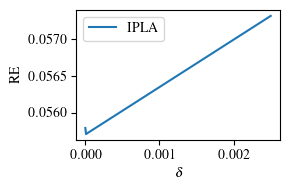

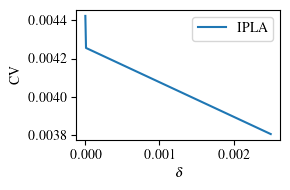

In [8]:
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "text.usetex": True,
    } 
    )

plt.figure(figsize=(3,2))
plt.plot(delta_vector, ipla_delta_re, color="C0", label="IPLA")
plt.legend()
plt.xlabel("$\\delta$")
plt.ylabel("RE")
plt.tight_layout()

plt.figure(figsize=(3,2))
plt.plot(delta_vector, ipla_delta_cv, color="C0", label="IPLA")
plt.legend()
plt.xlabel("$\\delta$")
plt.ylabel("CV")
plt.tight_layout()

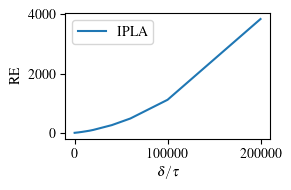

In [ ]:
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "text.usetex": True,
    } 
    )

plt.figure(figsize=(3,2))
plt.plot(delta_vector/time_step, ipla_delta_re, color="C0", label="IPLA")
plt.legend()
plt.xlabel("$\\delta/\\tau$")
plt.ylabel("RE")
plt.tight_layout()

plt.figure(figsize=(3,2))
plt.plot(delta_vector/time_step, ipla_delta_cv, color="C0", label="IPLA")
plt.legend()
plt.xlabel("$\\delta/\\tau$")
plt.ylabel("CV")
plt.tight_layout()